In [1]:
import numpy as np
import torch

# Note that I couldn't acquire the ADNI dataset in time. Hence MNIST was used as an example instead.
def load_mnist_data(test=False):
    if(test):
        f_images = open('data/mnist/t10k-images-idx3-ubyte', 'rb')
        f_labels = open('data/mnist/t10k-labels-idx1-ubyte', 'rb')
    else:
        f_images = open('data/mnist/train-images-idx3-ubyte', 'rb')
        f_labels = open('data/mnist/train-labels-idx1-ubyte', 'rb')

    f_images.seek(16)
    f_labels.seek(8)

    buf_images = f_images.read()
    buf_labels = f_labels.read()

    images = np.copy(
        np.frombuffer(buf_images, dtype=np.uint8).astype(np.float32)
    )
    images = images.reshape(-1, 1, 28, 28) / 256

    labels = np.copy(
        np.frombuffer(buf_labels, dtype=np.uint8)
    )
    labels_one_hot = np.zeros((labels.shape[0], 10))
    labels_one_hot[np.arange(labels.size), labels] = 1

    return images, labels


def sample(X, Y, batch_size=32):
    length = len(Y)
    idx = np.random.choice(np.arange(0, length),
                           size=(batch_size), replace=False)

    return X[idx], Y[idx]


In [14]:
from tqdm import trange
# from perceiver import PerceiverLogits
from model import Perceiver
import torch
from torch import nn, optim
import random
import numpy as np
import os


def set_random_seed(value):
    torch.manual_seed(value)
    np.random.seed(value)
    random.seed(value)

# Reproducibility
set_random_seed(10)


def evaluate(model, device='cuda'):
    model.eval()
    model = model.to(device)
    with torch.no_grad():
        X_test, Y_test = load_mnist_data(test=True)
        X_length = len(X_test)
        batch_size = 32

        correct = 0
        total = 0

        for i in range(X_length // batch_size):
            x = torch.from_numpy(
                X_test[i * batch_size:(i+1) * batch_size]
            ).float().to(device)
            y = torch.from_numpy(
                Y_test[i * batch_size:(i+1) * batch_size]
            ).long().to(device)

            y_ = model(x).argmax(dim=-1)

            total += len(y_)
            correct += (y_ == y).sum().item()

        return correct / total


def train(model, epochs=9, batch_size=32, device='cuda'):
    results = []
    losses = []
    model.train()
    model = model.to(device)
    gamma = 0.3
    optimizer = optim.Adam(model.parameters(), lr=0.03)
    scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer, step_size=3, gamma=gamma, last_epoch=-1, verbose=False)

    X_train, Y_train = load_mnist_data(test=False)
    X_length = len(X_train)

    for epoch in range(epochs):
        print('EPOCH', epoch, '[LEARNING RATE: ' + str(optimizer.param_groups[0]
                                                        ['lr']) + '; ACCURACY: ' + str(evaluate(model, device=device)) + ']')
        results.append(evaluate(model, device=device))

        t = trange(X_length // batch_size)
        for _ in t:
            optimizer.zero_grad()

            x, y = sample(X_train, Y_train, batch_size)
            x = torch.from_numpy(x).float().to(device)
            y = torch.from_numpy(y).long().to(device)

            y_ = model(x)
            loss = nn.NLLLoss()(y_, y)

            loss.backward()
            optimizer.step()

            t.set_description(str(loss.item())[0:5])
        scheduler.step()

        if(not os.path.exists('checkpoints')):
            os.mkdir('checkpoints')
        torch.save(model, 'checkpoints/epoch' + str(epoch))
    
    return results

In [17]:
model = Perceiver(
    depth=6,
    num_channels=1, # <- How many channels in the input? E.g. 3 for RGB.
    input_shape=(28, 28), # <- How big is the input in the different dimensions? E.g. (28, 28) for MNIST
    fourier_bands=4, # <- How many bands should the positional encoding have?
    num_latents=8, # <- How many latent vectors?
    latent_dim=16, # <- Model dimensionality. Every pixel/token/latent vector will have this size.
    latent_heads=8, # <- How many heads in self-attention? Cross-attention always has 1 head.
    attn_dropout=0.1, # <- Dropout
    num_features=10,
    self_per_cross_attn=6,
    device='cuda'
)

# Training
train(model, epochs=5) # saves checkpoints which can be used later donw the line for inference.

0.4099
0.9252
0.9374
0.9587
0.9605
0.9609


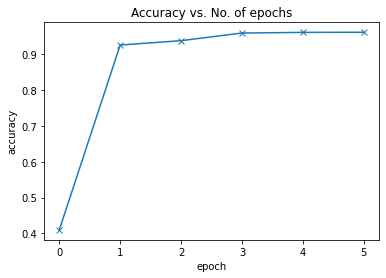

In [22]:
import matplotlib.pyplot as plt

# Read through pre-trained perceiver on selected epochs
res = []
for i in range(6):
  model = torch.load('./checkpoints/epoch' + str(i))
  eval = evaluate(model)
  res.append(eval)
  print(eval)

# Plot accuracy based on epochs
accuracies = res
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');